### Setup paths and load libraries

In [ ]:
import os
import pickle
import gzip
import torch
from metient.util import plotting_util as plutil
from lifelines import KaplanMeierFitter, CoxPHFitter
import pandas as pd
import matplotlib.pyplot as plt
from metient.util.globals import *
import pyreadr

REPO_DIR = os.path.join(os.getcwd(), "../../../")
PARAMS = "phyloccf_presences_05142024"
METIENT_OUTPUT_DIR = os.path.join(REPO_DIR, 'metient/data/tracerx_nsclc/metient_outputs')
CONIPHER_OUTPUT_DIR = os.path.join(METIENT_OUTPUT_DIR, f'pyclone_clustered_conipher_trees_{PARAMS}/calibrate/')
# Load tracerx clinical info
tracerx_patient_info = pyreadr.read_r(os.path.join('/data/morrisq/divyak/data/tracerx_nsclc_2023/20221109_TRACERx421_all_patient_df.rds'))[None]
print(tracerx_patient_info.columns)

# Load tracerx's seeding patterns
TRACERX_DATA_DIR = os.path.join(REPO_DIR, "metient/data/tracerx_nsclc/")
tracerx_seeding = pd.read_csv(os.path.join(TRACERX_DATA_DIR, "seedingTable.txt"), sep="\t")
tracerx_seeding.columns = ["patient_id", "tracerx_clonality","tracerx_phyletic", "tracerx_multitree_adjustment"] 
print(len(tracerx_seeding))


### Load migration histories for TRACERx patients

In [ ]:
def get_patients(pickle_files_dir):
    patients = set()
    for file in os.listdir(pickle_files_dir):
        if ".pkl.gz" in file:
            name = file.split(".")[0].replace("_calibrate", "")
            patients.add(name)
    return patients

def patient_in_dict(dct, patient):
    for patient_primary in dct:
        if patient == patient_primary.split("_")[0]:
            return True, patient_primary, dct[patient_primary]
    return False, None, None

def is_better_pattern(old_pattern, new_pattern):
    if "monoclonal" in new_pattern or "monophyletic" in new_pattern:
        return True
    return False


def load_patterns(pickle_files_dir):
    patients = get_patients(pickle_files_dir)
    seeding_patterns = dict()
    patients = ["CRUK0301_primary_SU_T1"]
    for patient in patients:
        print(patient)
        with gzip.open(os.path.join(pickle_files_dir, f"{patient}.pkl.gz"),'rb') as f:
            pckl = pickle.load(f)
        V = torch.tensor(pckl[OUT_LABElING_KEY][0])
        A = torch.tensor(pckl[OUT_ADJ_KEY][0])
        idx_to_label = pckl[OUT_IDX_LABEL_KEY][0]

        sites = pckl[OUT_SITES_KEY]
        primary_label =  "_".join(patient.split("_")[1:])
        tracerx_pattern = plutil.get_tracerx_seeding_pattern(V, A, sites, primary_label,idx_to_label)
        pattern = plutil.get_verbose_seeding_pattern(V, A)
       
        # For patients with multiple primaries
        patient_name = patient.split("_")[0]
        if patient_name in seeding_patterns:
            prev_tracerx_pattern = seeding_patterns[patient_name][1]
            # choose the run with the primary that was more parsimonious
            if is_better_pattern(prev_tracerx_pattern, tracerx_pattern):
                seeding_patterns[patient_name] = pattern, tracerx_pattern
        else:
            seeding_patterns[patient_name] = pattern, tracerx_pattern

    print(f"{len(seeding_patterns)} patients")
    return seeding_patterns

print(CONIPHER_OUTPUT_DIR)
all_inferred_patterns = load_patterns(CONIPHER_OUTPUT_DIR)
all_inferred_patterns

### Is there any relationship between seeding pattern and survival?

CRUK0352 polyclonal monophyletic polyclonal mixed
CRUK0478 polyclonal monophyletic polyclonal mixed
CRUK0084 Series([], Name: tracerx_clonality, dtype: object) Series([], Name: tracerx_multitree_adjustment, dtype: object)
CRUK0721 Series([], Name: tracerx_clonality, dtype: object) Series([], Name: tracerx_multitree_adjustment, dtype: object)
CRUK0620 Series([], Name: tracerx_clonality, dtype: object) Series([], Name: tracerx_multitree_adjustment, dtype: object)
CRUK0372 Series([], Name: tracerx_clonality, dtype: object) Series([], Name: tracerx_multitree_adjustment, dtype: object)
CRUK0301 Series([], Name: tracerx_clonality, dtype: object) Series([], Name: tracerx_multitree_adjustment, dtype: object)
CRUK0245 polyclonal monophyletic polyclonal mixed
P-value for impact_variable: 0.4329371050988894


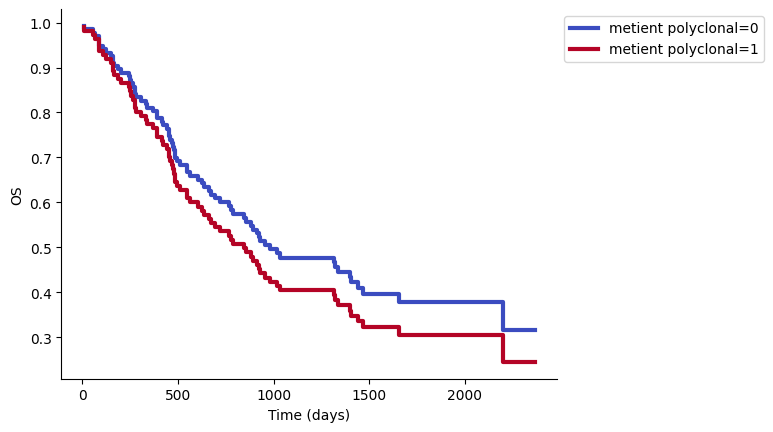

P-value for impact_variable: 0.6335435333624131


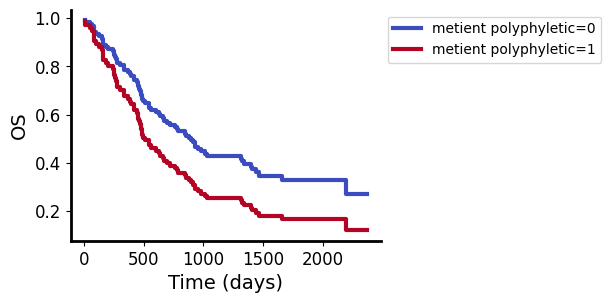

P-value for impact_variable: 0.2359972419631305


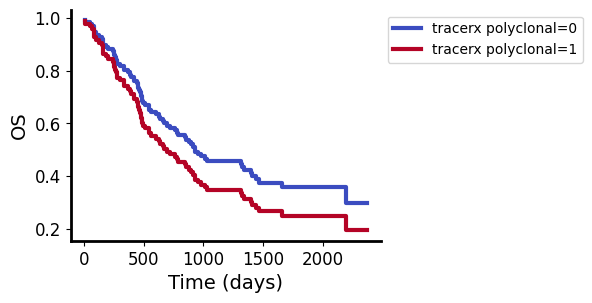

P-value for impact_variable: 0.7812881196936954


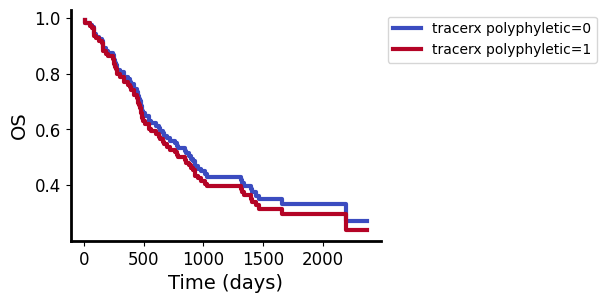

In [3]:

def cox(df, event):
    m = (df[event] == 1)
    # Fit the model
    T = df['OS']
    E = df["dead"]

    # ax = plt.subplot(111)
    # kmf_poly = KaplanMeierFitter()
    # kmf_poly.fit(durations = T[m], event_observed = E[m], label = event)
    # kmf_poly.plot_survival_function(ax = ax)

    # kmf_not_poly = KaplanMeierFitter()
    # kmf_not_poly.fit(T[~m], event_observed = E[~m], label = f"not {event}")
    # kmf_not_poly.plot_survival_function(ax = ax, at_risk_counts = True)

#     plt.title("Survival of different group")
#     plt.show()
#     plt.close()

    ax = plt.subplot(111)
    cph = CoxPHFitter().fit(df[['OS', 'dead', event]], 'OS', 'dead')
    summary = cph.summary
    p_value = summary.loc[event, 'p']
    print(f"P-value for impact_variable: {p_value}")
    
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 12
    plt.rcParams['lines.linewidth'] = 3
    plt.rcParams['figure.figsize'] = (4,3)
    plt.rcParams['axes.grid'] = False
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['axes.linewidth'] = 2.0
    cph.plot_partial_effects_on_outcome(ax=ax, covariates=event, values=[0, 1], cmap = 'coolwarm')
    ax.get_lines()[2].remove()  # Remove the baseline

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xlabel('Time (days)')
    plt.ylabel('OS')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

    plt.show()
    plt.close()

allowed_clonality = {"monoclonal", "polyclonal"}
allowed_phyletic = {"monophyletic", "polyphyletic"}
# Create a df with inferred pattern and survival
data = []
for patient in all_inferred_patterns:
    
    # Verify that inferred and tracerx patterns are one of the expected patterns
    metient_clonality = all_inferred_patterns[patient][1].split()[0]
    metient_phyletic = all_inferred_patterns[patient][1].split()[1]
    
    tracerx_subset = tracerx_seeding[tracerx_seeding['patient_id']==patient]
    tracerx_clonality = tracerx_subset['tracerx_clonality']
    tracerx_phyletic = tracerx_subset['tracerx_multitree_adjustment']
    if len(tracerx_clonality) == 0 or len(tracerx_phyletic) == 0:
        print(patient, tracerx_clonality, tracerx_phyletic)
        continue
    tracerx_clonality = tracerx_clonality.item()
    tracerx_phyletic = tracerx_phyletic.item()
    
    if metient_clonality not in allowed_clonality or metient_phyletic not in allowed_phyletic or tracerx_clonality not in allowed_clonality or tracerx_phyletic not in allowed_phyletic:
        print(patient, metient_clonality, metient_phyletic, tracerx_clonality, tracerx_phyletic)
        continue
    
    metient_is_polyclonal = int(metient_clonality == "polyclonal")
    metient_is_polyphyletic = int(metient_phyletic == "polyphyletic")
    tracerx_is_polyclonal = int(tracerx_clonality == "polyclonal")
    tracerx_is_polyphyletic = int(tracerx_phyletic == "polyphyletic")
    os_time = int(tracerx_patient_info[tracerx_patient_info['cruk_id']==patient]['os_time'])
    dead = int(tracerx_patient_info[tracerx_patient_info['cruk_id']==patient]['cens_os'])
    data.append([patient, metient_is_polyclonal, metient_is_polyphyletic, tracerx_is_polyclonal,tracerx_is_polyphyletic,  os_time, dead])

inferred_df = pd.DataFrame(data, columns=["patient", "metient polyclonal", "metient polyphyletic", "tracerx polyclonal", "tracerx polyphyletic", "OS", "dead"])
inferred_df

cox(inferred_df, "metient polyclonal")
cox(inferred_df, "metient polyphyletic")

cox(inferred_df, "tracerx polyclonal")
cox(inferred_df, "tracerx polyphyletic")



In [4]:
patient_data_all = pyreadr.read_r(os.path.join('/data/morrisq/divyak/data/tracerx_nsclc_2023/mutTableAll.cloneInfo.20220726.rda'))
patient_data_all_df = patient_data_all['mutTableAll']
print("Patient data columns:\n ", patient_data_all_df.columns)

patient_data_all_df = patient_data_all_df[['mutation_id', 'patient_id', 'Hugo_Symbol','exonic.func','NucleotideChange', 'RegionSum' , 'MajorCPN_SC', 'MinorCPN_SC', 'chr', 'start', 'stop', 'ref', 'var']]
unique_patients = patient_data_all_df['patient_id'].unique()
print("Number of unique patients:", len(unique_patients))
list(patient_data_all_df[(patient_data_all_df['patient_id']=='CRUK0609')&(patient_data_all_df['Hugo_Symbol']=='MTOR')]['RegionSum'])
    

Patient data columns:
  Index(['mutation_id', 'patient_id', 'tumour_id', 'chr', 'start', 'stop', 'ref',
       'var', 'Hugo_Symbol', 'func', 'exonic.func', 'NucleotideChange',
       'AAChange', 'GL_VAF', 'GL_nAlt', 'GL_depth', 'ITHState', 'RegionSum',
       'Is.present', 'PyCloneClonal_SC', 'PyCloneCluster_SC',
       'cleanCluster_SC', 'PhyloCCF_SC', 'combTiming_SC', 'MutCPN_SC',
       'MajorCPN_SC', 'MinorCPN_SC', 'DriverMut', 'treeClones',
       'seedingClones', 'clonalClones', 'sharedClones', 'primaryClones',
       'metClones'],
      dtype='object')
Number of unique patients: 126


['SU_FLN1:29/116;SU_T1.R1:56/204;SU_T1.R2:61/216;SU_T1.R3:40/198']